In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
import warnings
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
#warnings.filterwarnings('ignore')

In [2]:
def engineer_features(df):
    df['time'] = pd.to_datetime(df['time'], unit='s', errors='coerce')
    df['month'] = df['time'].dt.month

    # Extract day of the month (1-31)
    df['day'] = df['time'].dt.day


    # --- New Additions ---
    # Extract hour (0-23)
    df['hour'] = df['time'].dt.hour

    # Extract minute (0-59)
    df['minute'] = df['time'].dt.minute



    # --- End of New Additions ---

    # 3. Remove the original 'time' column
    df = df.drop(columns=['time'])
    # --- Clean up and drop NaNs (first ~200 rows) ---
    df = df.dropna().reset_index(drop=True)

    return df


In [ ]:
def identify_support_resistance_rolling(df, n_clusters=5, window_size=500,
                                        step_size=100, min_window=200):
    """
    Use rolling K-Means clustering to identify dynamic support and resistance levels

    Parameters:
    -----------
    df : DataFrame with OHLC data
    n_clusters : Number of S/R levels to identify (default 5)
    window_size : Size of rolling window for clustering (default 500)
    step_size : How many bars to move forward each iteration (default 100)
    min_window : Minimum data points needed before starting clustering (default 200)

    Returns:
    --------
    df : DataFrame with 'price_cluster', 'nearest_sr_level', and 'sr_levels' columns
    all_cluster_centers : Dictionary mapping index to cluster centers for that period
    """
    df['price_cluster'] = -1
    df['nearest_sr_level'] = np.nan
    df['sr_levels'] = None  # Will store list of S/R levels for each row

    all_cluster_centers = {}

    # Start from minimum window size
    for start_idx in range(0, len(df), step_size):
        # Define the window
        end_idx = min(start_idx + window_size, len(df))

        # For the first iteration, use data from beginning
        if start_idx == 0:
            window_start = 0
        else:
            window_start = max(0, end_idx - window_size)

        # Ensure we have enough data
        if end_idx - window_start < min_window:
            continue

        # Get price data for clustering (only lookback, no look-ahead)
        window_prices = df.iloc[window_start:end_idx]['close'].values.reshape(-1, 1)

        # Perform clustering on this window
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        kmeans.fit(window_prices)

        cluster_centers = sorted(kmeans.cluster_centers_.flatten())

        # Apply these cluster centers to the current batch
        # We label from start_idx to the next start_idx (or end of data)
        batch_end = min(start_idx + step_size, len(df))

        for i in range(start_idx, batch_end):
            if i >= len(df):
                break

            current_price = df.iloc[i]['close']

            # Find nearest cluster center
            nearest_level = min(cluster_centers, key=lambda level: abs(level - current_price))

            # Find which cluster this price belongs to
            cluster_idx = np.argmin([abs(current_price - center) for center in cluster_centers])

            df.at[df.index[i], 'price_cluster'] = cluster_idx
            df.at[df.index[i], 'nearest_sr_level'] = nearest_level
            df.at[df.index[i], 'sr_levels'] = cluster_centers.copy()

            # Store cluster centers for this index
            all_cluster_centers[i] = cluster_centers

    # Fill any remaining unlabeled rows at the beginning
    if df['nearest_sr_level'].isna().any():
        first_valid_idx = df['nearest_sr_level'].first_valid_index()
        if first_valid_idx is not None:
            first_valid_pos = df.index.get_loc(first_valid_idx)
            if first_valid_pos > 0:
                # Use the first valid cluster centers for earlier rows
                first_centers = all_cluster_centers[first_valid_pos]

                for i in range(first_valid_pos):
                    current_price = df.iloc[i]['close']
                    nearest_level = min(first_centers, key=lambda level: abs(level - current_price))
                    cluster_idx = np.argmin([abs(current_price - center) for center in first_centers])

                    df.at[df.index[i], 'price_cluster'] = cluster_idx
                    df.at[df.index[i], 'nearest_sr_level'] = nearest_level
                    df.at[df.index[i], 'sr_levels'] = first_centers.copy()

    return df, all_cluster_centers


def identify_support_resistance(df, n_clusters=5):
    """Use K-Means clustering to identify support and resistance levels"""
    prices = df['close'].values.reshape(-1, 1)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df['price_cluster'] = kmeans.fit_predict(prices)

    # Get cluster centers (support/resistance levels)
    cluster_centers = sorted(kmeans.cluster_centers_.flatten())

    # Assign nearest cluster center to each row
    df['nearest_sr_level'] = df['close'].apply(
        lambda x: min(cluster_centers, key=lambda level: abs(level - x))
    )

    return df, cluster_centers

In [4]:
def create_labels(df, cluster_centers, tolerance=0.0005, lookback=10, lookahead=20):
    """
    Create buy/sell labels based on price action around support/resistance
    with consolidation detection and breakout retest logic

    Label 0: Hold/No action
    Label 1: Buy signal
    Label 2: Sell signal

    Parameters:
    -----------
    df : DataFrame with OHLC data
    cluster_centers : Support/resistance levels from clustering
    tolerance : Price proximity threshold (default 0.0005 = 0.05%)
    lookback : Periods to look back for pattern confirmation
    lookahead : Periods to look ahead for future price validation
    """
    labels = np.zeros(len(df))
    sr_levels = sorted(cluster_centers)

    for i in range(lookback, len(df) - lookahead):
        current_price = df.iloc[i]['close']
        current_high = df.iloc[i]['high']
        current_low = df.iloc[i]['low']

        # Get historical and future price windows
        hist_window = df.iloc[i-lookback:i]
        future_window = df.iloc[i+1:i+lookahead+1]

        # Find nearest support and resistance
        lower_levels = [level for level in sr_levels if level < current_price]
        upper_levels = [level for level in sr_levels if level > current_price]

        support = lower_levels[-1] if lower_levels else sr_levels[0]
        resistance = upper_levels[0] if upper_levels else sr_levels[-1]

        # Calculate dynamic tolerance based on price level
        support_tol = support * tolerance
        resistance_tol = resistance * tolerance

        # ========== SCENARIO 1: CONSOLIDATION AT SUPPORT (BUY) ==========
        if abs(current_low - support) <= support_tol:
            # Check if we're consolidating (not in strong downtrend)
            recent_lows = hist_window['low'].values
            is_consolidating = np.std(recent_lows) < support * 0.01  # Low volatility

            # Look ahead for upward movement
            future_high = future_window['high'].max()
            future_gain = (future_high - current_price) / current_price

            if future_gain > 0.005:  # At least 0.5% gain potential
                labels[i] = 1
                continue

        # ========== SCENARIO 2: CONSOLIDATION AT RESISTANCE (SELL) ==========
        if abs(current_high - resistance) <= resistance_tol:
            # Check if we're consolidating (not in strong uptrend)
            recent_highs = hist_window['high'].values
            is_consolidating = np.std(recent_highs) < resistance * 0.01

            # Look ahead for downward movement
            future_low = future_window['low'].min()
            future_loss = (current_price - future_low) / current_price

            if future_loss > 0.005:  # At least 0.5% drop potential
                labels[i] = 2
                continue

        # ========== SCENARIO 3: BREAKOUT WITH RETEST (BUY) ==========
        # Check if resistance was recently broken
        resistance_broken = False
        breakout_idx = None

        for j in range(max(0, i-lookback), i):
            if (df.iloc[j-1]['close'] < resistance and
                df.iloc[j]['close'] > resistance):
                resistance_broken = True
                breakout_idx = j
                break

        if resistance_broken and breakout_idx is not None:
            # Check if current price is retesting the old resistance (now support)
            if abs(current_low - resistance) <= resistance_tol * 2:
                # Confirm price holds above and moves up
                if current_price > resistance * 0.998:  # Slightly above
                    future_high = future_window['high'].max()
                    if future_high > current_price * 1.005:
                        labels[i] = 1
                        continue

        # ========== SCENARIO 4: BREAKDOWN WITH RETEST (SELL) ==========
        # Check if support was recently broken
        support_broken = False
        breakdown_idx = None

        for j in range(max(0, i-lookback), i):
            if (df.iloc[j-1]['close'] > support and
                df.iloc[j]['close'] < support):
                support_broken = True
                breakdown_idx = j
                break

        if support_broken and breakdown_idx is not None:
            # Check if current price is retesting the old support (now resistance)
            if abs(current_high - support) <= support_tol * 2:
                # Confirm price fails to break above and moves down
                if current_price < support * 1.002:  # Slightly below
                    future_low = future_window['low'].min()
                    if future_low < current_price * 0.995:
                        labels[i] = 2
                        continue

        # ========== SCENARIO 5: RANGING MARKET - BUY LOW ==========
        # Price in lower third of support-resistance range
        range_size = resistance - support
        lower_third = support + range_size * 0.33

        if current_price <= lower_third:
            # Check if price bounces up
            future_high = future_window['high'].max()
            if future_high >= support + range_size * 0.6:  # Moves to upper range
                labels[i] = 1
                continue

        # ========== SCENARIO 6: RANGING MARKET - SELL HIGH ==========
        # Price in upper third of support-resistance range
        upper_third = resistance - range_size * 0.33

        if current_price >= upper_third:
            # Check if price falls down
            future_low = future_window['low'].min()
            if future_low <= support + range_size * 0.4:  # Moves to lower range
                labels[i] = 2
                continue

        # ========== SCENARIO 7: STRONG MOMENTUM BUY ==========
        # Price breaks resistance with strong volume/momentum
        if current_price > resistance * (1 + tolerance):
            # Confirm sustained move
            closes_above = (future_window['close'] > resistance).sum()
            if closes_above / len(future_window) > 0.6:  # 60% of future closes above
                labels[i] = 1
                continue

        # ========== SCENARIO 8: STRONG MOMENTUM SELL ==========
        # Price breaks support with strong volume/momentum
        if current_price < support * (1 - tolerance):
            # Confirm sustained move
            closes_below = (future_window['close'] < support).sum()
            if closes_below / len(future_window) > 0.6:  # 60% of future closes below
                labels[i] = 2
                continue

    df['label'] = labels.astype(int)

    # Print label distribution
    unique, counts = np.unique(labels, return_counts=True)
    label_dist = dict(zip(unique, counts))
    print(f"Label Distribution:")
    print(f"  Hold (0): {label_dist.get(0, 0)} ({label_dist.get(0, 0)/len(labels)*100:.1f}%)")
    print(f"  Buy (1):  {label_dist.get(1, 0)} ({label_dist.get(1, 0)/len(labels)*100:.1f}%)")
    print(f"  Sell (2): {label_dist.get(2, 0)} ({label_dist.get(2, 0)/len(labels)*100:.1f}%)")

    df = smooth_labels(df)
    return df


def smooth_labels(df, window=3):
    """
    Optional: Smooth labels to reduce noise by using majority vote in a window
    """
    labels = df['label'].values
    smoothed = labels.copy()

    for i in range(window, len(labels) - window):
        window_labels = labels[i-window:i+window+1]
        # Keep non-zero labels if they appear in majority
        non_zero = window_labels[window_labels != 0]
        if len(non_zero) >= window:
            smoothed[i] = np.median(non_zero)

    df['label'] = smoothed.astype(int)
    return df



In [5]:
def add_technical_indicators(df):
    """Add RSI, MACD, and other technical indicators"""

    # RSI (Relative Strength Index)
    def calculate_rsi(data, period=14):
        delta = data.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    df['rsi'] = calculate_rsi(df['close'])

    # MACD (Moving Average Convergence Divergence)
    exp1 = df['close'].ewm(span=12, adjust=False).mean()
    exp2 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = exp1 - exp2
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']

    # Moving Averages
    df['sma_20'] = df['close'].rolling(window=20).mean()
    df['sma_50'] = df['close'].rolling(window=50).mean()
    df['ema_12'] = df['close'].ewm(span=12, adjust=False).mean()

    # Bollinger Bands
    df['bb_middle'] = df['close'].rolling(window=20).mean()
    bb_std = df['close'].rolling(window=20).std()
    df['bb_upper'] = df['bb_middle'] + (bb_std * 2)
    df['bb_lower'] = df['bb_middle'] - (bb_std * 2)

    # ATR (Average True Range)
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift())
    low_close = np.abs(df['low'] - df['close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    df['atr'] = true_range.rolling(14).mean()

    # Momentum
    df['momentum'] = df['close'] - df['close'].shift(4)

    # Volume indicators
    df['volume_sma'] = df['volume'].rolling(window=20).mean()
    df['volume_ratio'] = df['volume'] / df['volume_sma']

    # Price rate of change
    df['roc'] = ((df['close'] - df['close'].shift(10)) / df['close'].shift(10)) * 100

    # Drop rows with NaN values
    df = df.dropna()

    return df

In [6]:
def plot_signals(df, cluster_centers):
    """Plot price chart with buy/sell signals"""
    fig, ax = plt.subplots(figsize=(15, 8))

    # Plot close price
    ax.plot(df.index, df['close'], label='Close Price', color='blue', alpha=0.6)

    # Plot support/resistance levels
    for level in cluster_centers:
        ax.axhline(y=level, color='gray', linestyle='--', alpha=0.3)

    # Plot buy signals
    buy_signals = df[df['label'] == 1]
    ax.scatter(buy_signals.index, buy_signals['close'],
               color='green', marker='^', s=100, label='Buy Signal', zorder=5)

    # Plot sell signals
    sell_signals = df[df['label'] == 2]
    ax.scatter(sell_signals.index, sell_signals['close'],
               color='red', marker='v', s=100, label='Sell Signal', zorder=5)

    ax.set_xlabel('Index')
    ax.set_ylabel('Price')
    ax.set_title('Trading Signals: Buy and Sell Points')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('trading_signals.png', dpi=300)
    plt.show()

    print(f"\nSignal Distribution:")
    print(f"Hold/No Action (0): {len(df[df['label'] == 0])}")
    print(f"Buy Signals (1): {len(df[df['label'] == 1])}")
    print(f"Sell Signals (2): {len(df[df['label'] == 2])}")

In [7]:


print("="*70)
print("TRADING SIGNAL CLASSIFICATION SYSTEM")
print("="*70)

# Step 1: Load data from Excel
print("\nStep 1: Loading data from Excel file...")
t_symbol = ["BTCUSD"]
n = 0
m_label = "Generated"+t_symbol[n]

df = pd.read_csv(m_label+ " dbot.csv")
df = engineer_features(df)





TRADING SIGNAL CLASSIFICATION SYSTEM

Step 1: Loading data from Excel file...


In [8]:
df

,open,high,low,close,volume,spread,month,day,hour,minute
0,13.69,13.78,13.40,13.61,69,0,7,21,10,0
1,13.61,13.81,13.45,13.70,64,0,7,22,10,0
2,13.70,13.76,13.51,13.68,49,0,7,23,10,0
3,13.68,14.10,13.60,13.98,71,0,7,24,10,0
4,13.98,14.72,13.76,14.05,186,0,7,25,10,0
...,...,...,...,...,...,...,...,...,...,...
728568,93008.50,93009.38,92861.00,92943.50,805,2522,12,3,13,40
728569,92941.00,93086.00,92941.00,93016.00,723,2522,12,3,13,45
728570,93015.00,93069.93,92978.44,92999.00,858,2522,12,3,13,50
728571,93000.00,93058.00,92985.00,93038.00,562,2520,12,3,13,55


In [9]:

# Step 2: Identify support/resistance
print("\nStep 2: Identifying support and resistance levels...")
df, cluster_centers = identify_support_resistance(df, n_clusters=3)
print(f"Support/Resistance levels: {cluster_centers}")


# Step 3: Create labels
print("\nStep 3: Creating buy/sell labels...")
df = create_labels(df, cluster_centers)









Step 2: Identifying support and resistance levels...
Support/Resistance levels: [np.float64(14589.76920381689), np.float64(51815.369609741836), np.float64(101891.04504928974)]

Step 3: Creating buy/sell labels...


KeyboardInterrupt: 

In [ ]:
# Step 4: Add technical indicators
print("\nStep 4: Adding technical indicators...")
df = add_technical_indicators(df)
print(f"Final dataset shape: {df.shape}")

In [ ]:
print(f"Data loaded: {len(df)} rows")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

In [10]:
df

,open,high,low,close,volume,spread,month,day,hour,minute,...,ema_12,bb_middle,bb_upper,bb_lower,atr,momentum,volume_sma,volume_ratio,roc,label
49,5.03,5.49,4.63,4.77,147,0,9,10,10,0,...,7.114446,8.4160,12.040086,4.791914,0.910714,-2.09,138.45,1.061755,-45.733788,0
50,4.77,7.40,4.60,5.86,452,0,9,11,10,0,...,6.921454,8.1435,11.669621,4.617379,1.040000,-1.33,159.70,2.830307,-28.536585,0
51,5.86,6.58,5.41,6.08,213,0,9,12,10,0,...,6.792000,7.9025,11.291565,4.513435,1.050000,-0.45,162.45,1.311173,-25.943971,0
52,6.08,6.09,5.70,5.80,51,0,9,13,10,0,...,6.639385,7.6455,10.838601,4.452399,1.033571,0.77,160.25,0.318253,-31.603774,0
53,5.80,5.85,5.32,5.62,89,0,9,14,10,0,...,6.482556,7.3840,10.318251,4.449749,1.039286,0.85,162.60,0.547355,-31.295844,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728568,93008.50,93009.38,92861.00,92943.50,805,2522,12,3,13,40,...,92992.919147,93048.3000,93320.990956,92775.609044,162.823571,-86.00,1061.25,0.758539,-0.125725,0
728569,92941.00,93086.00,92941.00,93016.00,723,2522,12,3,13,45,...,92996.470047,93043.3250,93314.480087,92772.169913,157.323571,-12.50,1023.10,0.706676,0.053783,0
728570,93015.00,93069.93,92978.44,92999.00,858,2522,12,3,13,50,...,92996.859271,93035.0500,93300.679718,92769.420282,153.314286,-29.50,994.45,0.862788,0.067789,0
728571,93000.00,93058.00,92985.00,93038.00,562,2520,12,3,13,55,...,93003.188614,93025.0000,93272.747324,92777.252676,147.207143,30.00,951.70,0.590522,0.071527,0



Step 5: Visualizing trading signals...


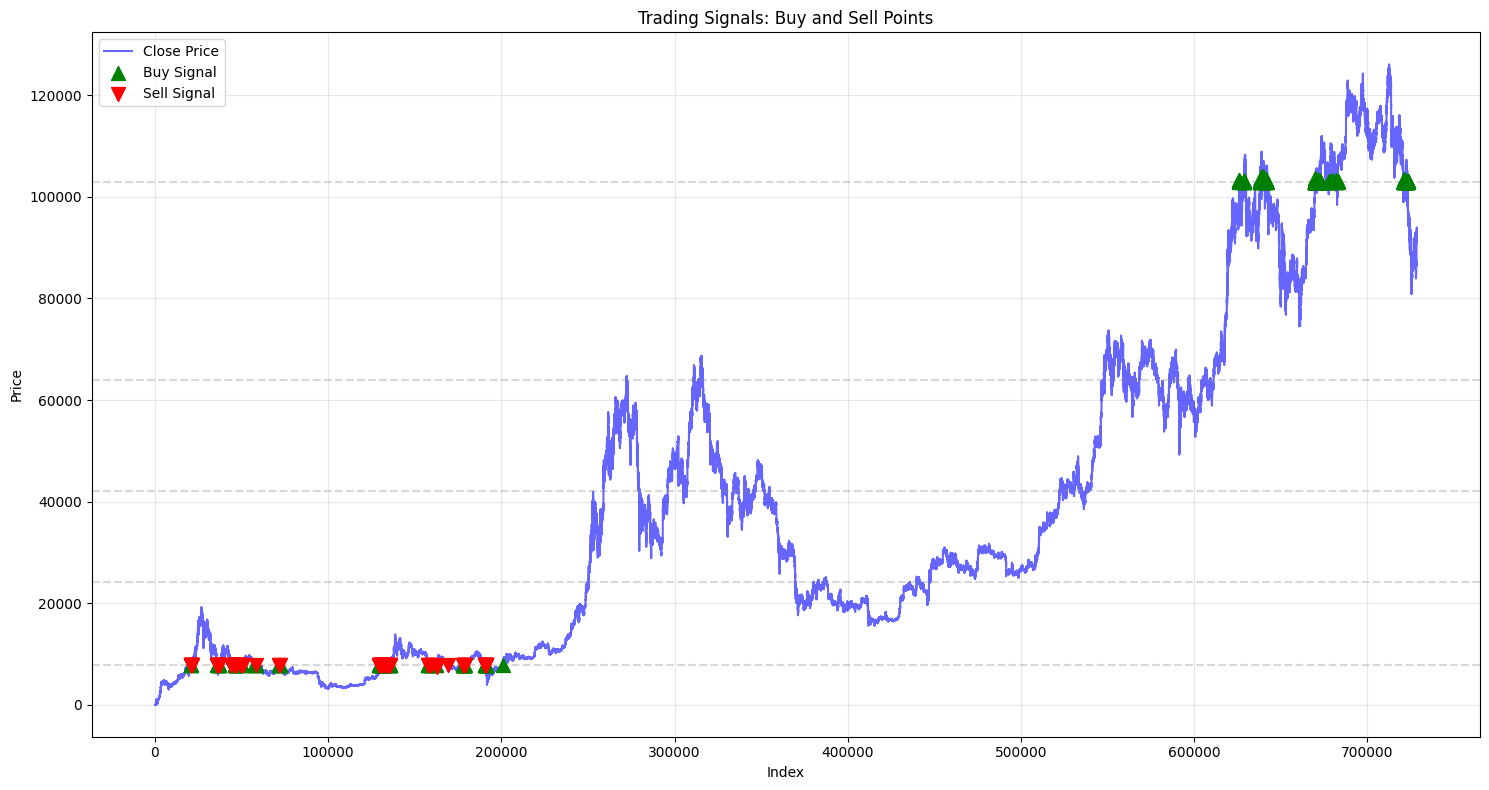


Signal Distribution:
Hold/No Action (0): 728006
Buy Signals (1): 386
Sell Signals (2): 122


In [11]:

# Step 5: Visualize signals
print("\nStep 5: Visualizing trading signals...")
plot_signals(df, cluster_centers)



In [ ]:
# Prepare features and labels
feature_cols = ['open', 'high', 'low', 'close', 'volume', 'spread',
                'hour', 'minute', 'day', 'month', 'day_of_week',
                'rsi', 'macd', 'macd_signal', 'macd_hist',
                'sma_20', 'sma_50', 'ema_12',
                'bb_upper', 'bb_middle', 'bb_lower', 'atr',
                'momentum', 'volume_ratio', 'roc', 'price_cluster']

X = df[feature_cols].values
y = df['label'].values

X_real = X[-1000:]
y_real = y[-1000:]

X = X[:-1000]
y = y[:-1000]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_real_scaled = scaler.transform(X_real)

In [ ]:
import joblib
joblib.dump(scaler, 'scaler.joblib')

In [ ]:

# Define models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'SVC': SVC(kernel='rbf', random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}

print("\n" + "="*70)
print("TRAINING CLASSIFICATION MODELS")
print("="*70)

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train
    model.fit(X_train_scaled, y_train)

    # Predict
    y_pred = model.predict(X_test_scaled)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'predictions': y_pred,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(results[name]['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'confusion_matrix_{name.replace(" ", "_")}.png', dpi=300)
    plt.show()

In [ ]:
"""Train a deep neural network for classification"""

print("\n" + "="*70)
print("TRAINING DEEP NEURAL NETWORK")
print("="*70)

# Convert labels to categorical
num_classes = len(np.unique(y_train))
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)
y_live_cat = keras.utils.to_categorical(y_real,num_classes)
# Build model
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Architecture:")
model.summary()



In [ ]:
es = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=2)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=2)
mc = ModelCheckpoint(m_label + 'lstm_best.keras', monitor='val_loss', save_best_only=True, verbose=2)
# Train
history = model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    verbose=1,
    callbacks=[es, rlr, mc ],
)



In [ ]:

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('dnn_training_history.png', dpi=300)
plt.show()



In [ ]:

model = load_model(m_label + 'lstm_best.keras')
# Evaluate
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\n\nDeep Neural Network Accuracy: {accuracy:.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Deep Neural Network')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_DNN.png', dpi=300)
plt.show()

In [ ]:

# Summary
print("\n" + "="*70)
print("FINAL RESULTS SUMMARY")
print("="*70)

for name, result in results.items():
    print(f"{name}: {result['accuracy']:.4f}")
print(f"Deep Neural Network: {accuracy:.4f}")

print("\nAll models trained successfully!")
print("Confusion matrices and plots saved to current directory.")